In [59]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.optimize as sciopt

In [60]:
# Read the new data, dump statistics, and populate derived metadata
obsdata = pd.read_csv('../data_files/good_qual_1deg.csv', parse_dates=['Date'])
print('** SUMMARY STATISTICS **')
print('Unique observation names:', len(obsdata.groupby('Observation')))
print('Total 1-degree slices:', len(obsdata))
print('Starting date:', obsdata['Date'].min())
print('Ending date:', obsdata['Date'].max())
print('Time span:', obsdata['Date'].max()-obsdata['Date'].min())
obsdata['Mu'] = np.abs(np.cos(np.radians(obsdata['Mean Emission'])))
obsdata['Mu0'] = np.abs(np.cos(np.radians(obsdata['Incidence'])))

** SUMMARY STATISTICS **
Unique observation names: 152
Total 1-degree slices: 36466
Starting date: 2004-06-20 20:03:28
Ending date: 2017-09-07 02:15:23
Time span: 4826 days 06:11:55


In [61]:
# Define phase functions and optimization routines
def hg(alpha, g):
    return (1-g**2) / (1+g**2+2*g*np.cos(alpha))**1.5 / 2

def hg_func(params, xpts):
    ypts = None
    for i in range(len(params)//2):
        g, scale = params[i*2:i*2+2]
        if ypts is None:
            ypts = scale * hg(xpts, g)
        else:
            ypts += scale * hg(xpts, g)
    return ypts

def hg_fit_func(params, xpts, ypts):
    ypts2 = hg_func(params, xpts)
    return ypts - ypts2

# Fit a phase curve and remove data points more than nstd sigma away
# Use std=None to not remove outliers
# Do the modeling on a copy of the data so we can remove outliers
def fit_iterative_phase_function(n_hg, nstd, data):
    phasedata = data.copy()
    initial_guess = []
    bounds1 = []
    bounds2 = []
    for i in range(n_hg):
        initial_guess.append(-.5)
        initial_guess.append(1.)
        bounds1.append(-1.)
        bounds1.append(0.)
        bounds2.append(1.)
        bounds2.append(1000.)
    while True:
        phase_radians = np.radians(phasedata['Mean Phase'])
        params = sciopt.least_squares(hg_fit_func, initial_guess,
                                      bounds=(bounds1, bounds2),
                                      args=(phase_radians,
                                            phasedata['Normal EW']))
        params = params['x']
        phase_model = hg_func(params, phase_radians)
        ratio = np.log10(phasedata['Normal EW'] / phase_model)
        std = np.std(ratio)
        print('Ratio min', ratio.min(), 'Max', ratio.max(), 'Sigma', std)
        if nstd is None:
            break
        oldlen = len(phasedata)
        phasedata = phasedata[ratio.abs() < nstd*std]
        if len(phasedata) == oldlen:
            break
    return params, phasedata

def print_params(params):
    total_scale = sum(params[i] for i in range(1,len(params),2))
    for i in range(0,len(params)//2):
        g, scale = params[i*2:i*2+2]
        print('g%d = %.3f weight%d = %.3f' % (i+1, g, i+1, scale/total_scale))

# Phase Curve with All Slices

Ratio min -0.5653225072541392 Max 0.8160552177981648 Sigma 0.11567588020761996
Ratio min -0.22018782962643238 Max 0.25826170292445194 Sigma 0.08952914632414333
Ratio min -0.17252051804860097 Max 0.18878097109020045 Sigma 0.07813019211067969
Ratio min -0.15338467981865977 Max 0.1614182585593433 Sigma 0.07206910638321498
Ratio min -0.1429392203523707 Max 0.1472763325891723 Sigma 0.06836622317067188
Ratio min -0.13625581966477432 Max 0.13878895288510965 Sigma 0.0659350751420908
Ratio min -0.13125290836110684 Max 0.13318212195919293 Sigma 0.0642141738822447
Ratio min -0.12800234422591847 Max 0.12916085971242453 Sigma 0.06314455377362165
Ratio min -0.12571497097024587 Max 0.12693701292785328 Sigma 0.06231360255850481
Ratio min -0.12434350435951001 Max 0.12512794107685882 Sigma 0.06167361470672062
Ratio min -0.12306352646644249 Max 0.12380329198693173 Sigma 0.06117016781126614
Ratio min -0.12221535138357177 Max 0.12275444334359747 Sigma 0.060817507218629885
Ratio min -0.1214131722193533 Max 

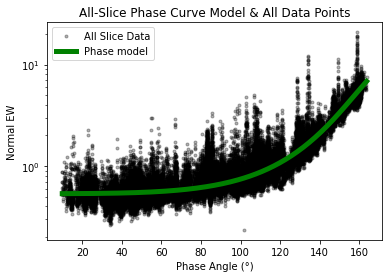

In [62]:
all_slice_params, all_slice_used_data = fit_iterative_phase_function(2, 2, obsdata)
print('Final all-slice params')
print_params(all_slice_params)
obsdata['Phase Model'] = hg_func(all_slice_params, np.radians(obsdata['Mean Phase']))

# Plot the individual slice data points
plt.plot(obsdata['Mean Phase'], obsdata['Normal EW'], '.', color='black', alpha=0.3, 
         label='All Slice Data')

# Plot the phase model sampled at 1-degree intervals
xrange = np.arange(obsdata['Mean Phase'].min(), obsdata['Mean Phase'].max()+1)
all_slice_phase_model = hg_func(all_slice_params, np.radians(xrange))
plt.plot(xrange, all_slice_phase_model, '-', color='green', lw=5, label='Phase model')
plt.yscale('log')
plt.legend()
plt.xlabel('Phase Angle (°)')
plt.ylabel('Normal EW')
_=plt.title('All-Slice Phase Curve Model & All Data Points')

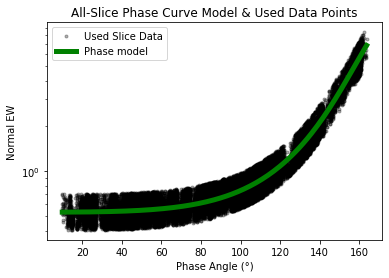

In [63]:
# Now plot the same phase curve, but with only the data points that were used in the 
# model fit
plt.plot(all_slice_used_data['Mean Phase'], all_slice_used_data['Normal EW'], 
         '.', color='black', alpha=0.3, label='Used Slice Data')
plt.plot(xrange, all_slice_phase_model, '-', color='green', lw=5, label='Phase model')
plt.yscale('log')
plt.legend()
plt.xlabel('Phase Angle (°)')
plt.ylabel('Normal EW')
_=plt.title('All-Slice Phase Curve Model & Used Data Points')

Text(0, 0.5, 'Normal EW / Full Phase Model')

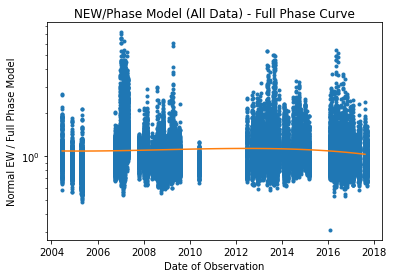

In [64]:
# Plot NEW/Phase Curve ratio vs. Time with a fit curve for all data
time0 = np.datetime64('1970-01-01T00:00:00')
obsdata['Date_secs'] = (obsdata['Date']-time0).dt.total_seconds()/86400
obsdata['Phase Curve Ratio'] = obsdata['Normal EW'] / obsdata['Phase Model']
timecoeff = np.polyfit(obsdata['Date_secs'], obsdata['Phase Curve Ratio'], 3)
plt.plot(obsdata['Date'], obsdata['Phase Curve Ratio'], '.')
timerange = np.arange(obsdata['Date_secs'].min(), obsdata['Date_secs'].max(), 100)
timefit = np.polyval(timecoeff, timerange)
plt.plot(timerange, timefit, '-')
plt.yscale('log')
_=plt.title('NEW/Phase Model (All Data) - Full Phase Curve')
plt.xlabel('Date of Observation')
plt.ylabel('Normal EW / Full Phase Model')

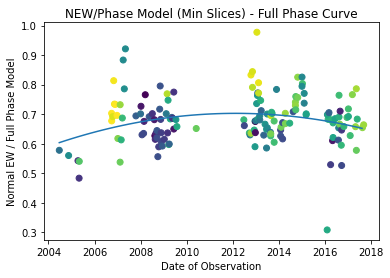

In [65]:
# Plot minimum-slices-only NEW/Phase Curve ratio vs. Time with a fit curve
mindata=obsdata.copy().iloc[obsdata.groupby('Observation').idxmin()['Normal EW']]
maxdata=obsdata.copy().iloc[obsdata.groupby('Observation').idxmax()['Normal EW']]
mindata['All Phase Model'] = hg_func(all_slice_params, np.radians(mindata['Mean Phase']))
mindata['All Phase Curve Ratio'] = mindata['Normal EW'] / mindata['All Phase Model']
timecoeff = np.polyfit(mindata['Date_secs'], mindata['All Phase Curve Ratio'], 2)
timerange = np.arange(mindata['Date_secs'].min(), mindata['Date_secs'].max(), 100)
timefit = np.polyval(timecoeff, timerange)
plt.scatter(mindata['Date'], mindata['All Phase Curve Ratio'], c=mindata['Mean Phase'])
plt.plot(timerange, timefit, '-')
plt.xlabel('Date of Observation')
plt.ylabel('Normal EW / Full Phase Model')
_=plt.title('NEW/Phase Model (Min Slices) - Full Phase Curve')

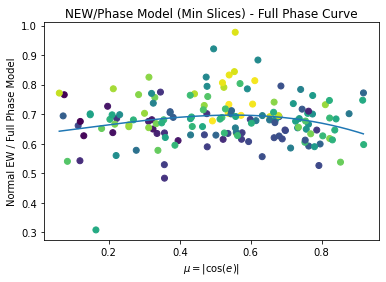

In [66]:
# Plot minimum-slices-only NEW/Phase Curve ratio vs. u
# This checks for sensitivity of the phase curve to emission angle to see if
# the simple mu adjustment is good enough
mindata=obsdata.copy().iloc[obsdata.groupby('Observation').idxmin()['Normal EW']]
maxdata=obsdata.copy().iloc[obsdata.groupby('Observation').idxmax()['Normal EW']]
mindata['All Phase Model'] = hg_func(all_slice_params, np.radians(mindata['Mean Phase']))
mindata['All Phase Curve Ratio'] = mindata['Normal EW'] / mindata['All Phase Model']
mucoeff = np.polyfit(mindata['Mu'], mindata['All Phase Curve Ratio'], 3)
murange = np.arange(mindata['Mu'].min(), mindata['Mu'].max(), .001)
mufit = np.polyval(mucoeff, murange)
plt.scatter(mindata['Mu'], mindata['All Phase Curve Ratio'], c=mindata['Mean Phase'])
plt.plot(murange, mufit, '-')
plt.xlabel('$\mu=|\cos(e)|$')
plt.ylabel('Normal EW / Full Phase Model')
_=plt.title('NEW/Phase Model (Min Slices) - Full Phase Curve')

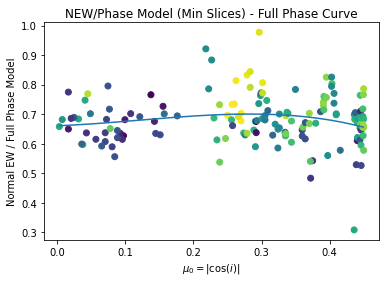

In [67]:
# Plot minimum-slices-only NEW/Phase Curve ratio vs. u0
# This checks for sensitivity of the phase curve to emission angle to see if
# the simple mu adjustment is good enough
mindata=obsdata.copy().iloc[obsdata.groupby('Observation').idxmin()['Normal EW']]
maxdata=obsdata.copy().iloc[obsdata.groupby('Observation').idxmax()['Normal EW']]
mindata['All Phase Model'] = hg_func(all_slice_params, np.radians(mindata['Mean Phase']))
mindata['All Phase Curve Ratio'] = mindata['Normal EW'] / mindata['All Phase Model']
mucoeff = np.polyfit(mindata['Mu0'], mindata['All Phase Curve Ratio'], 3)
murange = np.arange(mindata['Mu0'].min(), mindata['Mu0'].max(), .001)
mufit = np.polyval(mucoeff, murange)
plt.scatter(mindata['Mu0'], mindata['All Phase Curve Ratio'], c=mindata['Mean Phase'])
plt.plot(murange, mufit, '-')
plt.xlabel('$\mu_0=|\cos(i)|$')
plt.ylabel('Normal EW / Full Phase Model')
_=plt.title('NEW/Phase Model (Min Slices) - Full Phase Curve')

# Phase Curve with Minimum Slices Only

Ratio min -0.3311427553717266 Max 0.16154292414379956 Sigma 0.055804821031607825
Final min-slice params
g1 = -0.136 weight1 = 0.211
g2 = 0.621 weight2 = 0.789


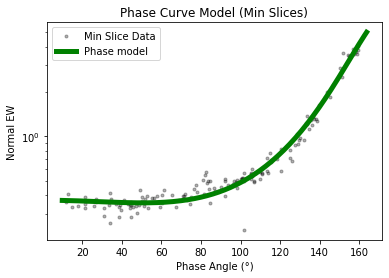

In [68]:
min_slice_params, min_slice_used_data = fit_iterative_phase_function(2, None, mindata)
print('Final min-slice params')
print_params(min_slice_params)
mindata['Phase Model'] = hg_func(min_slice_params, np.radians(mindata['Mean Phase']))

# Plot the individual slice data points
plt.plot(mindata['Mean Phase'], mindata['Normal EW'], '.', color='black', alpha=0.3, 
         label='Min Slice Data')

# Plot the phase model sampled at 1-degree intervals
xrange = np.arange(obsdata['Mean Phase'].min(), obsdata['Mean Phase'].max()+1)
min_slice_phase_model = hg_func(min_slice_params, np.radians(xrange))
plt.plot(xrange, min_slice_phase_model, '-', color='green', lw=5, label='Phase model')
plt.yscale('log')
plt.legend()
plt.xlabel('Phase Angle (°)')
plt.ylabel('Normal EW')
_=plt.title('Phase Curve Model (Min Slices)')

** Statistics - ratio of full phase curve / min phase curve
Ratio min: 1.3222821525265747
Ratio max: 1.5810194028247189
Ratio mean: 1.4702137095278889
Ratio median: 1.483833566835372


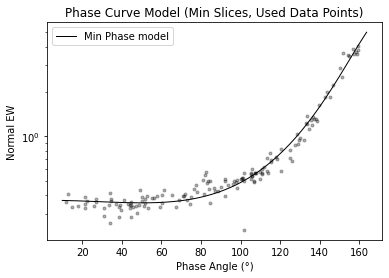

In [69]:
plt.plot(min_slice_used_data['Mean Phase'], min_slice_used_data['Normal EW'], '.', color='black', alpha=0.3)
# plt.plot(xrange, all_slice_phase_model, '-', color='green', lw=5, label='Full Phase model')
plt.plot(xrange, min_slice_phase_model, '-', color='black', lw=1, label='Min Phase model')
plt.yscale('log')
plt.legend()
plt.xlabel('Phase Angle (°)')
plt.ylabel('Normal EW')
_=plt.title('Phase Curve Model (Min Slices, Used Data Points)')
print('** Statistics - ratio of full phase curve / min phase curve')
ratio = all_slice_phase_model / min_slice_phase_model
print('Ratio min:', ratio.min())
print('Ratio max:', ratio.max())
print('Ratio mean:', ratio.mean())
print('Ratio median:', np.median(ratio))

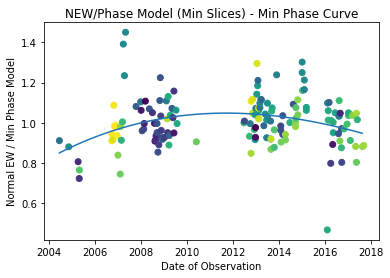

In [70]:
mindata['Phase Curve Ratio'] = mindata['Normal EW'] / mindata['Phase Model']
timecoeff = np.polyfit(mindata['Date_secs'], mindata['Phase Curve Ratio'], 3)
plt.scatter(mindata['Date'], mindata['Phase Curve Ratio'], c=mindata['Mean Phase'])
timerange = np.arange(mindata['Date_secs'].min(), mindata['Date_secs'].max(), 100)
timefit = np.polyval(timecoeff, timerange)
plt.plot(timerange, timefit, '-')
plt.xlabel('Date of Observation')
plt.ylabel('Normal EW / Min Phase Model')
_=plt.title('NEW/Phase Model (Min Slices) - Min Phase Curve')

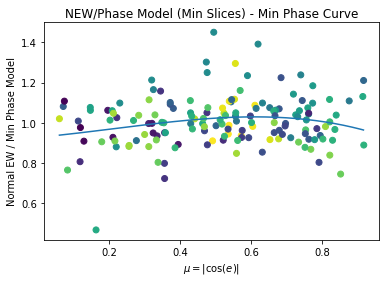

In [71]:
# Plot minimum-slices-only NEW/Phase Curve ratio vs. u
# This checks for sensitivity of the phase curve to emission angle to see if
# the simple mu adjustment is good enough
mucoeff = np.polyfit(mindata['Mu'], mindata['Phase Curve Ratio'], 3)
murange = np.arange(mindata['Mu'].min(), mindata['Mu'].max(), .001)
mufit = np.polyval(mucoeff, murange)
plt.scatter(mindata['Mu'], mindata['Phase Curve Ratio'], c=mindata['Mean Phase'])
plt.plot(murange, mufit, '-')
plt.xlabel('$\mu=|\cos(e)|$')
plt.ylabel('Normal EW / Min Phase Model')
_=plt.title('NEW/Phase Model (Min Slices) - Min Phase Curve')

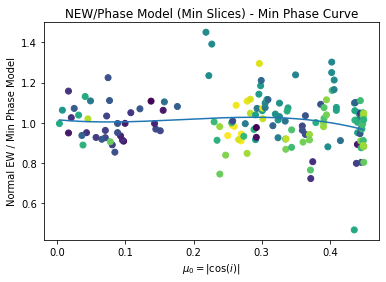

In [72]:
# Plot minimum-slices-only NEW/Phase Curve ratio vs. u0
# This checks for sensitivity of the phase curve to emission angle to see if
# the simple mu adjustment is good enough
mucoeff = np.polyfit(mindata['Mu0'], mindata['Phase Curve Ratio'], 3)
murange = np.arange(mindata['Mu0'].min(), mindata['Mu0'].max(), .001)
mufit = np.polyval(mucoeff, murange)
plt.scatter(mindata['Mu0'], mindata['Phase Curve Ratio'], c=mindata['Mean Phase'])
plt.plot(murange, mufit, '-')
plt.xlabel('$\mu_0=|\cos(i)|$')
plt.ylabel('Normal EW / Min Phase Model')
_=plt.title('NEW/Phase Model (Min Slices) - Min Phase Curve')

# Phase Curve with Maximum Slices Only

Ratio min -0.36633820903837544 Max 0.4886778442470386 Sigma 0.16606142265184928
Final max-slice params
g1 = 0.167 weight1 = 0.596
g2 = 0.676 weight2 = 0.404


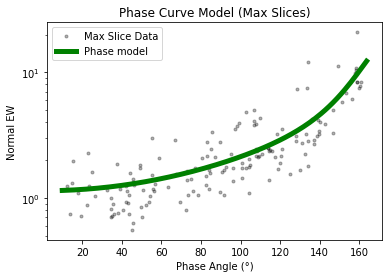

In [73]:
max_slice_params, max_slice_used_data = fit_iterative_phase_function(2, None, maxdata)
print('Final max-slice params')
print_params(max_slice_params)
maxdata['Phase Model'] = hg_func(max_slice_params, np.radians(maxdata['Mean Phase']))

# Plot the individual slice data points
plt.plot(maxdata['Mean Phase'], maxdata['Normal EW'], '.', color='black', alpha=0.3, 
         label='Max Slice Data')

# Plot the phase model sampled at 1-degree intervals
xrange = np.arange(obsdata['Mean Phase'].min(), obsdata['Mean Phase'].max()+1)
max_slice_phase_model = hg_func(max_slice_params, np.radians(xrange))
plt.plot(xrange, max_slice_phase_model, '-', color='green', lw=5, label='Phase model')
plt.yscale('log')
plt.legend()
plt.xlabel('Phase Angle (°)')
plt.ylabel('Normal EW')
_=plt.title('Phase Curve Model (Max Slices)')

** Statistics - ratio of full phase curve / min phase curve
Ratio min: 0.34920856738740047
Ratio max: 0.5578459089131325
Ratio mean: 0.4180586973179369
Ratio median: 0.4083883852703031


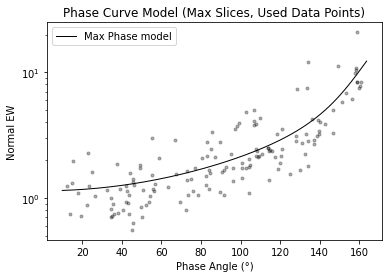

In [74]:
plt.plot(max_slice_used_data['Mean Phase'], max_slice_used_data['Normal EW'], '.', color='black', alpha=0.3)
# plt.plot(xrange, all_slice_phase_model, '-', color='green', lw=5, label='Full Phase model')
plt.plot(xrange, max_slice_phase_model, '-', color='black', lw=1, label='Max Phase model')
plt.yscale('log')
plt.legend()
plt.xlabel('Phase Angle (°)')
plt.ylabel('Normal EW')
_=plt.title('Phase Curve Model (Max Slices, Used Data Points)')
print('** Statistics - ratio of full phase curve / min phase curve')
ratio = all_slice_phase_model / max_slice_phase_model
print('Ratio min:', ratio.min())
print('Ratio max:', ratio.max())
print('Ratio mean:', ratio.mean())
print('Ratio median:', np.median(ratio))

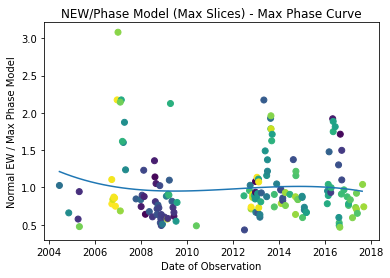

In [75]:
maxdata['Phase Curve Ratio'] = maxdata['Normal EW'] / maxdata['Phase Model']
timecoeff = np.polyfit(maxdata['Date_secs'], maxdata['Phase Curve Ratio'], 3)
plt.scatter(maxdata['Date'], maxdata['Phase Curve Ratio'], c=maxdata['Mean Phase'])
timerange = np.arange(maxdata['Date_secs'].min(), maxdata['Date_secs'].max(), 100)
timefit = np.polyval(timecoeff, timerange)
plt.plot(timerange, timefit, '-')
plt.xlabel('Date of Observation')
plt.ylabel('Normal EW / Max Phase Model')
_=plt.title('NEW/Phase Model (Max Slices) - Max Phase Curve')

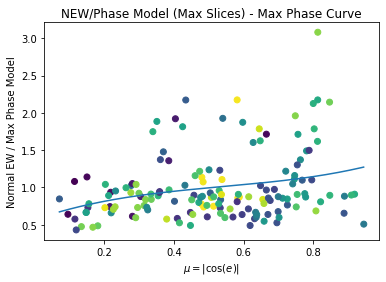

In [76]:
# Plot maximum-slices-only NEW/Phase Curve ratio vs. u
# This checks for sensitivity of the phase curve to emission angle to see if
# the simple mu adjustment is good enough
mucoeff = np.polyfit(maxdata['Mu'], maxdata['Phase Curve Ratio'], 3)
murange = np.arange(maxdata['Mu'].min(), maxdata['Mu'].max(), .001)
mufit = np.polyval(mucoeff, murange)
plt.scatter(maxdata['Mu'], maxdata['Phase Curve Ratio'], c=maxdata['Mean Phase'])
plt.plot(murange, mufit, '-')
plt.xlabel('$\mu=|\cos(e)|$')
plt.ylabel('Normal EW / Max Phase Model')
_=plt.title('NEW/Phase Model (Max Slices) - Max Phase Curve')

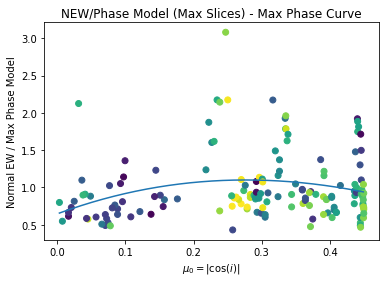

In [77]:
# Plot maximum-slices-only NEW/Phase Curve ratio vs. u0
# This checks for sensitivity of the phase curve to emission angle to see if
# the simple mu adjustment is good enough
mucoeff = np.polyfit(maxdata['Mu0'], maxdata['Phase Curve Ratio'], 3)
murange = np.arange(maxdata['Mu0'].min(), maxdata['Mu0'].max(), .001)
mufit = np.polyval(mucoeff, murange)
plt.scatter(maxdata['Mu0'], maxdata['Phase Curve Ratio'], c=maxdata['Mean Phase'])
plt.plot(murange, mufit, '-')
plt.xlabel('$\mu_0=|\cos(i)|$')
plt.ylabel('Normal EW / Max Phase Model')
_=plt.title('NEW/Phase Model (Max Slices) - Max Phase Curve')